# BERT + ROBERTA

In [ ]:
!pip install transformers
!pip install clean-text
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
from cleantext import clean
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [ ]:
path = '/content/tweets_labelled_09042020_16072020.csv'
df = pd.read_csv(path, sep = ';')
df.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


In [ ]:
df.dropna(inplace= True)

In [ ]:
date, time = [], []
for i in df['created_at']:
  d,t = i.split(' ')
  date.append(d)
  time.append(t)
df['date'] = pd.to_datetime(date)
df['time'] = pd.to_datetime(time)
df.drop('created_at', axis = 1, inplace= True)
df.head()

,id,text,sentiment,date,time
0,77522,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,2020-04-15,2022-07-17 01:03:46+00:00
1,661634,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,2020-06-25,2022-07-17 06:20:06+00:00
2,413231,Net issuance increases to fund fiscal programs...,positive,2020-06-04,2022-07-17 15:41:45+00:00
3,760262,RT @bentboolean: How much of Amazon's traffic ...,positive,2020-07-03,2022-07-17 19:39:35+00:00
4,830153,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,2020-07-09,2022-07-17 14:39:14+00:00


In [ ]:
tweets_per_day = df['date'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

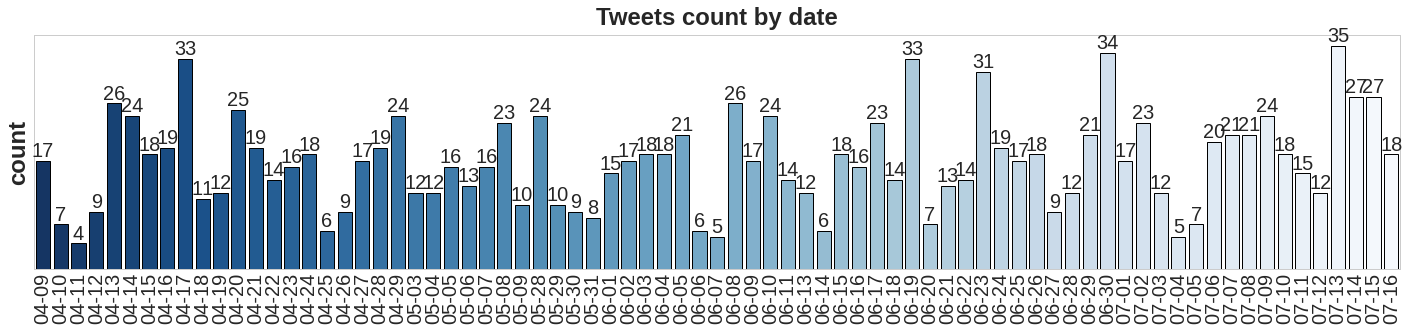

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
!pip install tqdm
from tqdm import tqdm
import collections

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#checking the tickers
tick_re = re.compile(r'(^\$[A-Z,&,0-9]{1,6})')
hash_re = re.compile(r'#\w+')

tick_dic = collections.defaultdict(int)
hash_dic = collections.defaultdict(int)

for t in tqdm(df['text']):
    for w in t.split():
        if tick_re.fullmatch(w):
            tick_dic[w[1:]] += 1    
        w = w.lower()
        if hash_re.fullmatch(w):
            hash_dic[w] +=1

tick_df = pd.DataFrame.from_dict(tick_dic,orient='index').rename(columns={0:'count'}).sort_values('count',ascending = False)
tags_df = pd.DataFrame.from_dict(hash_dic,orient='index').rename(columns={0:'count'}).sort_values('count',ascending = False)

100%|██████████| 1300/1300 [00:00<00:00, 17301.92it/s]


Text(0.5, 1.0, 'Top 20 hashtags')

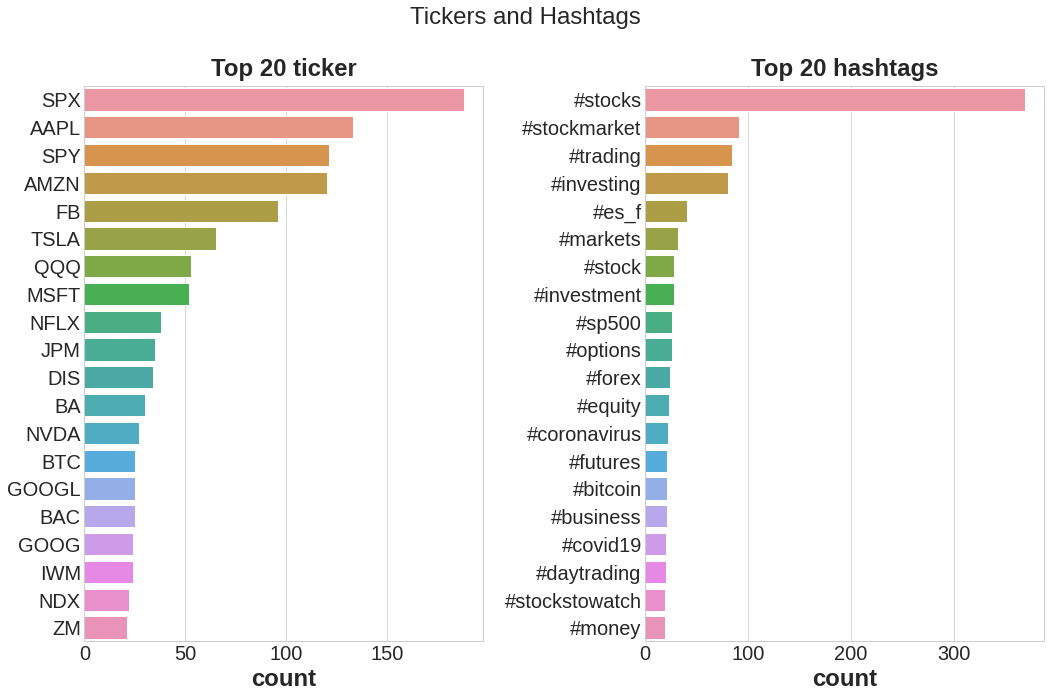

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,10) )
plt.rc('font', size = 20)

plt.suptitle('Tickers and Hashtags', )
plt.subplots_adjust(wspace=0.4)

# sns.set(font_scale = 1.5)
sns.barplot(x = tick_df['count'][:20], y = tick_df.index[:20], ax = ax[0])
ax[0].set_title('Top 20 ticker')

sns.barplot(x = tags_df['count'][:20], y = tags_df.index[:20], ax = ax[1])
ax[1].set_title('Top 20 hashtags')

# plt.figure(dpi = 300);

In [ ]:
tick_df.head()

,count
SPX,188
AAPL,133
SPY,121
AMZN,120
FB,96


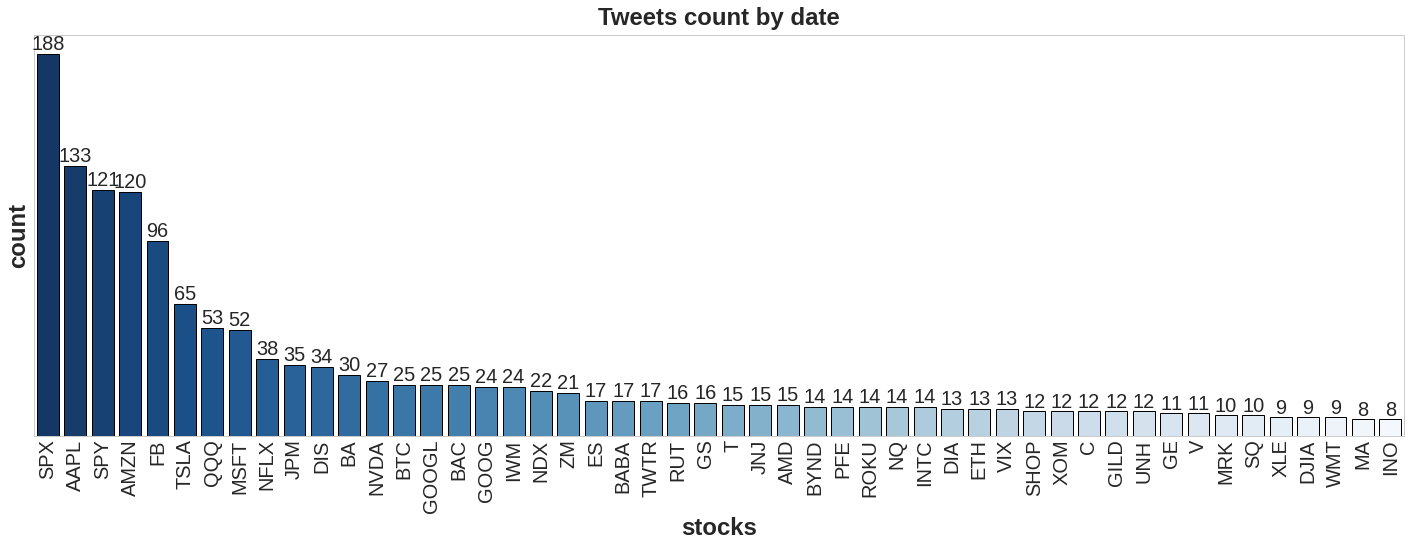

In [ ]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x = tick_df.index[:50], 
                 y = 'count',
                 data=tick_df[:50],
                 edgecolor = 'black',
                 ci=False, 
                 palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('stocks')
plt.xticks(rotation = 90)
plt.show()

## Deep Cleaning

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

df = df[['text','sentiment']]
STOPWORDS = set(stopwords.words('english')).union({'rt', 'retweet', 'spx', 'spy', 'sp500', 'nasdaq'})


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Clean emojis from text
def strip_emoji(text):
    return clean(text, no_emoji=True) #remove emoji

#Strip the stopwords
def strip_stopwords(text):
  return " ".join([word for word in str(text).split() if word.lower() not in STOPWORDS])

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    # banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    # table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)
    

In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(strip_stopwords(t)))))))

In [ ]:
df['text_clean'] = texts_new

#spectating 5 tweets before and after preprocessing
from prettytable import PrettyTable
t = PrettyTable(['Old text', 'CLeaned text'])
for i in range(5):
  t.add_row([df.loc[i,'text'], df.loc[i, 'text_clean']])
print(t)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                            Old text                                                                                                            |                                                                                   CLeaned text                                                                                  |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
df['text_len'] = text_len

In [ ]:
df.head()

,text,sentiment,text_clean,text_len
0,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,"yo enter win 1,000 monarch tokens us stock mar...",15
1,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,srilanka surcharge fuel removed! surcharge rs...,22
2,Net issuance increases to fund fiscal programs...,positive,net issuance increases fund fiscal programs > ...,31
3,RT @bentboolean: How much of Amazon's traffic ...,positive,much amazon's traffic served fastly? help us f...,12
4,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,ryzen 4000 desktop cpus looking 'great' track...,9


In [ ]:
import wordcloud
from wordcloud import WordCloud

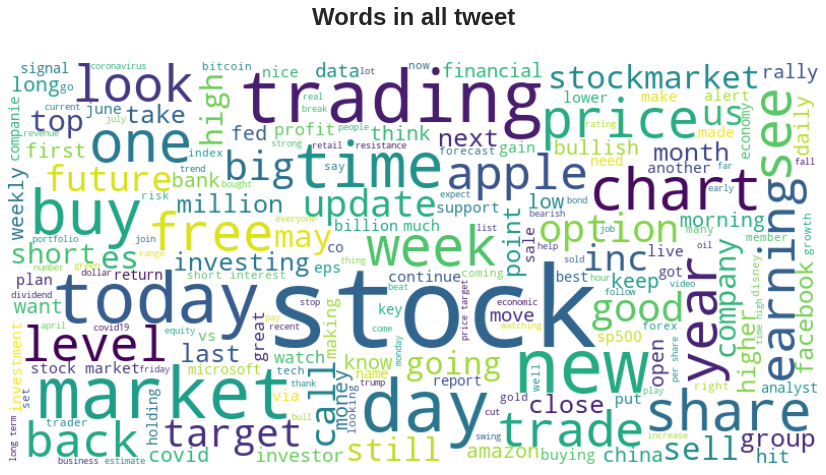

In [ ]:
words = ' '.join([text for text in df['text_clean']])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_font_size=110).generate(words)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all tweet\n', fontsize=24)
plt.axis('off')
plt.show()

In [ ]:
# We see there are lot of tickers here, so we will create a seperate df without tickers as they don't contain the sentiment information

# getting the list of tickers
# find a specific table by table count

from bs4 import BeautifulSoup
import requests

res = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df_ticker = pd.read_html(str(table))
list_ticker = df_ticker[0].to_json(orient='records')

#visualize the output
list_ticker = list_ticker.lower()
list_ticker[:500]

'[{"symbol":"mmm","security":"3m","sec filings":"reports","gics sector":"industrials","gics sub-industry":"industrial conglomerates","headquarters location":"saint paul, minnesota","date first added":"1976-08-09","cik":66740,"founded":"1902"},{"symbol":"aos","security":"a. o. smith","sec filings":"reports","gics sector":"industrials","gics sub-industry":"building products","headquarters location":"milwaukee, wisconsin","date first added":"2017-07-26","cik":91142,"founded":"1916"},{"symbol":"abt",'

The number of tickers found:  503  number of companies: 503


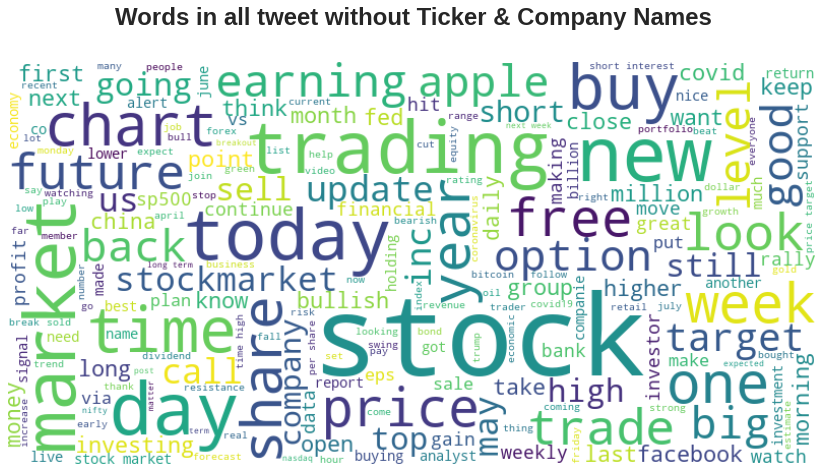

In [ ]:
#extracting tickers from the raw output
tickerRE= r"(?<=symbol\":\")[^\"]*"
tickerNameRE = r"(?<=security\":\")[^\"]*"
absoluteTickers = re.findall(tickerRE, list_ticker)
absoluteTickerNames = re.findall(tickerNameRE, list_ticker)
print("The number of tickers found: ", len(absoluteTickers)," number of companies:",  len(absoluteTickerNames))

not_ticker = [] # list of words in each row of df except for Ticker
for text in df['text_clean']:
    w = ' '
    for word in text.split():
        if word.lower() not in absoluteTickers+absoluteTickerNames:
          w = w + word + ' '
    not_ticker.append(w)
         
wordcloud = WordCloud(width=800, height=400, background_color='white', max_font_size=110).generate(" ".join(not_ticker))
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all tweet without Ticker & Company Names\n', fontsize=24)
plt.axis('off')
plt.show()

In [ ]:
df['text_clean'] = not_ticker 
df.head()

,text,sentiment,text_clean,text_len
0,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive,"yo enter win 1,000 monarch tokens us stock ma...",15
1,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative,srilanka surcharge fuel removed! surcharge rs...,22
2,Net issuance increases to fund fiscal programs...,positive,net issuance increases fund fiscal programs >...,31
3,RT @bentboolean: How much of Amazon's traffic ...,positive,much amazon's traffic served fastly? help us ...,12
4,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive,ryzen 4000 desktop cpus looking 'great' track...,9


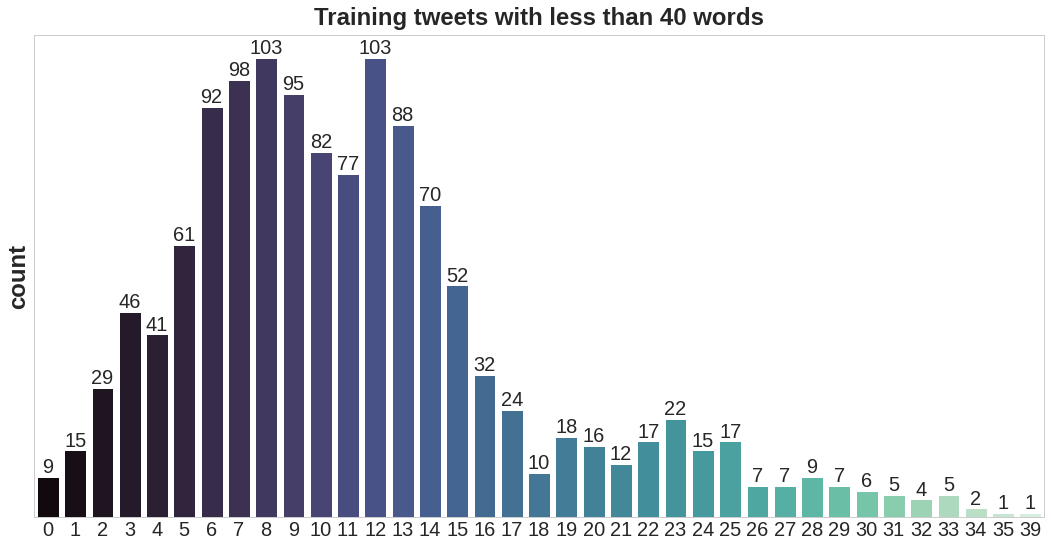

In [ ]:
plt.figure(figsize=(15,8))

ax = sns.countplot(x='text_len', data=df[df['text_len']<40], palette='mako')
plt.title('Training tweets with less than 40 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
print(f" DF SHAPE: {df.shape}")

 DF SHAPE: (1300, 4)


In [ ]:
#picking rows having words greateer than 4 
df = df[df['text_len'] > 4]
print(f" DF SHAPE: {df.shape}")

 DF SHAPE: (1160, 4)


## Training data deeper cleaning

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 92


The long tokenized sentences (with more than 80 tokens ):

In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 760, TEXT:  bearish engulfing daily appearances since 2010: 85 close 5 days later : avg: 0.79 sd: 1.84 worst: -3.78 best: 6.78 10 days later: avg: 1.32 sd: 3.23 worst: -4.94 best: 18.85 30 days later: avg: 2.24 sd: 5.63 worst: -14.42 best: 31.26 


In [ ]:
df['token_lens'] = token_lens
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,text,sentiment,text_clean,text_len,token_lens
852,$MSFT Bearish Engulfing\nDaily appearances sin...,negative,bearish engulfing daily appearances since 201...,42,92
1037,"New 6-Month Lows (Top 10): $HTZ -16.160%, $SHI...",negative,"new 6-month lows (top 10): -16.160%, -10.970%...",15,73
615,#ORR.96m at 1.51g/t. 7m at 86.39g/t.Main trend...,positive,orr.96m 1.51g/t. 7m 86.39g/t.main trend 6km. ...,32,71
49,Available #onhand #stocks of REGULAR #CYTOKIT ...,neutral,available onhand stocks regular cytokit text ...,19,71
741,Available #onhand #stocks of REGULAR #CYTOKIT ...,neutral,available onhand stocks regular cytokit text ...,19,71
242,$CRI #Chargeurs S.A. Chargeurs : Q1 naturally ...,neutral,chargeurs s.a. chargeurs : q1 naturally hit c...,30,69
672,Grab This #opportunity \n\n#Offer Valid Till 2...,positive,grab opportunity offer valid till 21-04-2020 ...,41,67
73,ABG Sundal Collier - #TF Bank AB TF Bank - Loa...,negative,abg sundal collier - tf bank ab tf bank - loa...,34,64
1009,$AWOX #AwoX SA AWOX - BUY | EUR2(+125%) A new ...,positive,"awox sa awox - buy | eur2(+125%) new name, ne...",35,64
1047,Hearing a lot about how frothy the markets are...,neutral,"hearing lot frothy markets are, quick valuati...",34,63


In [ ]:
#shuffling the indices
df = df.sample(frac=1).reset_index(drop=True)

Sentiment column Analysis

In [ ]:
df['sentiment'].value_counts()

positive    483
neutral     351
negative    326
Name: sentiment, dtype: int64

In [ ]:
df['sentiment'] = df['sentiment'].map({'positive':2, 'negative': 0, 'neutral':1})
df['sentiment'].value_counts()

2    483
1    351
0    326
Name: sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')]

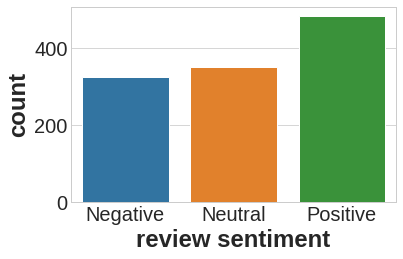

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])

## Splitting the data into train-test

In [ ]:
df_train = df.sample(frac = 0.9)
df_test = df.drop(df_train.index)
df_train.shape

(1044, 5)

In [ ]:
df_test.shape

(116, 5)

In [ ]:
# Class Balancing by RandomOverSampler for the training set
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df_train['text_clean']).reshape(-1, 1), np.array(df_train['sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'sentiment']);

In [ ]:
train_os['sentiment'].value_counts()

2    438
1    438
0    438
Name: sentiment, dtype: int64

Train - Validation - Test split

In [ ]:
# X = train_os['text_clean'].values
# y = train_os['sentiment'].values

X = df_train['text_clean'].values #del
y = df_train['sentiment'].values #delete

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['sentiment'].values

In [ ]:
# One hot encoding

y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 939
VALIDATION DATA: 105
TESTING DATA: 116


## Baseline model: Naive Bayes Classifier
Before implementing BERT, we will define a simple Naive Bayes baseline model to classify the tweets


In [ ]:
#tokenize the count vectorizer
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

nb_clf = MultinomialNB()

nb_clf.fit(X_train_tf, y_train_le)

nb_pred = nb_clf.predict(X_test_tf)

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.78      0.19      0.31        36
     Neutral       0.60      0.26      0.36        35
    Positive       0.45      0.91      0.60        45

    accuracy                           0.49       116
   macro avg       0.61      0.45      0.42       116
weighted avg       0.60      0.49      0.44       116



## BERT Sentiment Analysis

In [ ]:
MAX_LEN=128

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

# BERT modelling
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model


model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_11[0][0]',               
                                thPoolingAndCrossAt               'input_12[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
30/30 [==============================] - 40s 842ms/step - loss: 1.0717 - categorical_accuracy: 0.4260 - val_loss: 1.0277 - val_categorical_accuracy: 0.5429
Epoch 2/4
30/30 [==============================] - 23s 757ms/step - loss: 0.9539 - categorical_accuracy: 0.5335 - val_loss: 0.9975 - val_categorical_accuracy: 0.5048
Epoch 3/4
30/30 [==============================] - 23s 767ms/step - loss: 0.8094 - categorical_accuracy: 0.6624 - val_loss: 0.9608 - val_categorical_accuracy: 0.5619
Epoch 4/4
30/30 [==============================] - 23s 774ms/step - loss: 0.6291 - categorical_accuracy: 0.7646 - val_loss: 0.9213 - val_categorical_accuracy: 0.6381


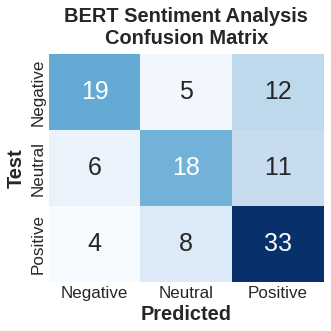

In [ ]:
# BERT Results
result_bert = model.predict([test_input_ids,test_attention_masks])

y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.66      0.53      0.58        36
     Neutral       0.58      0.51      0.55        35
    Positive       0.59      0.73      0.65        45

   micro avg       0.60      0.60      0.60       116
   macro avg       0.61      0.59      0.59       116
weighted avg       0.61      0.60      0.60       116
 samples avg       0.60      0.60      0.60       116



# RoBERTa Sentiment Analysis


In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

MAX_LEN=128

def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

def create_model(bert_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

roberta_model = TFRobertaModel.from_pretrained('roberta-base')

In [ ]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

#### Roberta results

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [ ]:

print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

# RESULT SUMMARY

In [ ]:
print('Classification Report for BERT:\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
print('Classification Report for RoBERTa:\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

Classification Matrix Comparison

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()